In [ ]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Data cleaning 

Purpose: tidy **product_info.csv** into an analysis-ready table.

Main steps: drop noisy columns `cols_to_drop`, remove rows missing `rating` or `ingredients`, normalize category hierarchy (fill secondary/tertiary), parse `highlights` and `ingredients` into lists and counts.

Outputs: **products_cleaned_base.csv**, **highlight_tag_counts.csv**, **ingredient_token_counts.csv**.

In [ ]:
# ----------------------------------------------------
# 1. Load our data
# ----------------------------------------------------

INPUT_PATH = "data/product_info.csv"
OUTPUT_CLEANED_PATH = "products_cleaned_base.csv"
OUTPUT_HIGHLIGHT_COUNTS = "highlight_tag_counts.csv"
OUTPUT_INGREDIENT_COUNTS = "ingredient_token_counts.csv"

df = pd.read_csv(INPUT_PATH)

# ----------------------------------------------------
# 2. Drop unwanted columns
# ----------------------------------------------------
cols_to_drop = [
    "size",
    "variation_type",
    "variation_value",
    "variation_desc",
    "value_price_usd",
    "sale_price_usd",
    "child_max_price",
    "child_min_price",
]

df = df.drop(columns=cols_to_drop, errors="ignore")

# ----------------------------------------------------
# 3. Drop rows with NaN in rating or ingredients
# ----------------------------------------------------
df = df[df["rating"].notna()]
df = df[df["ingredients"].notna()]

# ----------------------------------------------------
# 4. Clean category hierarchy: primary / secondary / tertiary
# ----------------------------------------------------

def fill_secondary(row):
    sec = row.get("secondary_category")
    if pd.isna(sec):
        prim = row.get("primary_category", "Unknown")
        return f"{prim} General"
    return sec

df["secondary_category"] = df.apply(fill_secondary, axis=1)

# Ttreat NaNs as "General"
if "tertiary_category" in df.columns:
    df["tertiary_category"] = df["tertiary_category"].fillna("General")

# ----------------------------------------------------
# 5. Parse 'highlights' column and prepare tag selection
# ----------------------------------------------------
def parse_list_string(x):
    """
    Safely parse a string that looks like a Python list, e.g.
    "['Vegan', 'Matte Finish']" -> ['Vegan', 'Matte Finish'].
    If NaN or parsing fails, return [].
    """
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return parsed
        else:
            return []
    except Exception:
        
        return []

# New column with parsed highlights as list
if "highlights" in df.columns:
    df["highlights_list"] = df["highlights"].apply(parse_list_string)
else:
    df["highlights_list"] = [[] for _ in range(len(df))]

# Count all highlight tags
all_highlight_tags = [
    tag.strip()
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str)
]

highlight_counter = Counter(all_highlight_tags)


highlight_counts_df = (
    pd.DataFrame(
        [{"tag": tag, "count": count} for tag, count in highlight_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

highlight_counts_df.to_csv(OUTPUT_HIGHLIGHT_COUNTS, index=False)
print(f"Saved highlight tag counts to: {OUTPUT_HIGHLIGHT_COUNTS}")
print(highlight_counts_df.head(15))


df["n_highlights"] = df["highlights_list"].apply(len)

# ----------------------------------------------------
# 6. Parse 'ingredients' and data-driven refinement
# ----------------------------------------------------

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

# join list and lowercase
def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    # join with commas for separation
    text = ", ".join([str(x) for x in ing_list])
    return text.lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)


ingredient_tokens = []

for text in df["ingredients_text"]:
    if not text:
        continue
   
    parts = text.split(",")
    for p in parts:
        token = p.strip()
        if token:
            ingredient_tokens.append(token)

ingredient_counter = Counter(ingredient_tokens)

# Choose top 200
TOP_N_INGREDIENTS = 200
top_ingredients = ingredient_counter.most_common(TOP_N_INGREDIENTS)

ingredient_counts_df = pd.DataFrame(
    [{"ingredient_token": ing, "count": cnt} for ing, cnt in top_ingredients]
).sort_values("count", ascending=False)

ingredient_counts_df.to_csv(OUTPUT_INGREDIENT_COUNTS, index=False)
print(f"Saved ingredient token counts to: {OUTPUT_INGREDIENT_COUNTS}")
print(ingredient_counts_df.head(15))

# ----------------------------------------------------
# 7. Save base cleaned dataset
# ----------------------------------------------------
df.to_csv(OUTPUT_CLEANED_PATH, index=False)
print(f"Saved cleaned dataset (with parsed highlights/ingredients) to: {OUTPUT_CLEANED_PATH}")


Saved highlight tag counts to: highlight_tag_counts.csv
                                  tag  count
0                               Vegan   2365
1                        Cruelty-Free   1574
2                    Clean at Sephora   1438
3                    Without Parabens   1282
4                   Good for: Dryness   1119
5                           Hydrating   1100
6   Good for: Dullness/Uneven Texture    856
7         Without Sulfates SLS & SLES    727
8                        Long-wearing    686
9             Clean + Planet Positive    658
10                     All Hair Types    632
11               Good for: Anti-Aging    585
12                    Hyaluronic Acid    560
13                 Without Phthalates    479
14                     Fragrance Free    477
Saved ingredient token counts to: ingredient_token_counts.csv
                ingredient_token  count
0                       glycerin   4087
1                 phenoxyethanol   3802
2                caprylyl glycol   2713
3 

In [3]:
df = pd.read_csv("products_cleaned_base.csv")

def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["highlights_list"] = df["highlights"].apply(parse_list_string)

hsel = pd.read_csv("highlight_features_selected.csv")

for tag in hsel["tag"]:
    col_name = "tag_" + tag.lower().replace(" ", "_").replace("/", "_").replace(":", "").replace(",", "").replace("&", "and")
    df[col_name] = df["highlights_list"].apply(lambda tags: int(tag in tags))

df["n_highlights"] = df["highlights_list"].apply(len)


In [4]:
df = pd.read_csv("products_cleaned_base.csv")

def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    return ", ".join([str(x) for x in ing_list]).lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)

isel = pd.read_csv("ingredient_features_selected.csv", sep=";")

group_to_tokens = {}
for _, row in isel.iterrows():
    group = row["group_name"]
    token = str(row["token"]).lower()
    group_to_tokens.setdefault(group, []).append(token)

for group_name, tokens in group_to_tokens.items():
    df[group_name] = df["ingredients_text"].apply(
        lambda txt: int(any(tok in txt for tok in tokens))
    )

df["n_ingredients"] = df["ingredients_text"].apply(
    lambda txt: len([p for p in txt.split(",") if p.strip()])
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   product_id                    7322 non-null   object 
 1   product_name                  7322 non-null   object 
 2   brand_id                      7322 non-null   int64  
 3   brand_name                    7322 non-null   object 
 4   loves_count                   7322 non-null   int64  
 5   rating                        7322 non-null   float64
 6   reviews                       7322 non-null   float64
 7   ingredients                   7322 non-null   object 
 8   price_usd                     7322 non-null   float64
 9   limited_edition               7322 non-null   int64  
 10  new                           7322 non-null   int64  
 11  online_only                   7322 non-null   int64  
 12  out_of_stock                  7322 non-null   int64  
 13  sep

In [6]:
df.to_csv("products_final.csv", index=False)

# 2. Basic Overview

In [7]:

DATA_PATH = "products_final.csv" 
df = pd.read_csv(DATA_PATH)


print("Shape:", df.shape)
df.head()

Shape: (7322, 42)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,ingredients,price_usd,limited_edition,...,has_antioxidant_vitamins,has_niacinamide,has_caffeine,has_adenosine,has_barrier_soothing,has_chemical_sunscreen,has_mineral_sunscreen,has_common_preservatives,has_hair_conditioning_agents,n_ingredients
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,0,...,0,0,0,0,0,1,0,0,0,94
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,13
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12


In [8]:
num_cols = ["price_usd", "loves_count", "rating", "reviews", "n_highlights", "n_ingredients"]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price_usd,7322.0,50.520610,47.669602,3.0,25.000000,35.00000,58.00000,449.0
loves_count,7322.0,31479.851543,68960.425831,0.0,4285.750000,10849.50000,29041.25000,1401068.0
rating,7322.0,4.199126,0.495827,1.0,3.995875,4.28885,4.52475,5.0
reviews,7322.0,478.301147,1125.133923,1.0,31.000000,144.00000,453.00000,21281.0
n_highlights,7322.0,3.749659,2.407591,0.0,2.000000,5.00000,6.00000,9.0
n_ingredients,7322.0,35.048211,34.133443,1.0,19.000000,28.00000,40.00000,720.0


Boxplots for some numerical variables of interest 

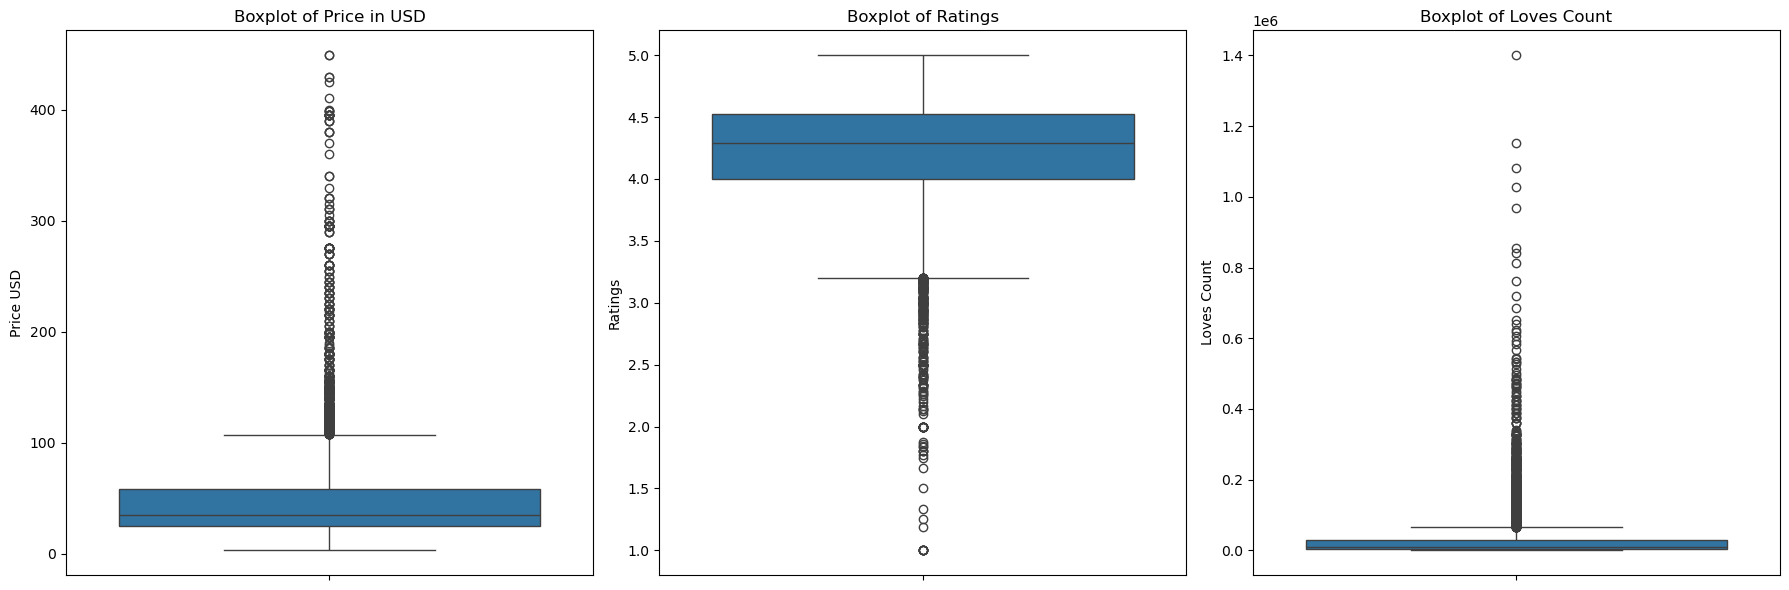

In [15]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for 'price_usd'
sns.boxplot(y=df['price_usd'], ax=axes[0])
axes[0].set_title('Boxplot of Price in USD')
axes[0].set_ylabel('Price USD')

# Boxplot for 'ratings'
sns.boxplot(y=df['rating'], ax=axes[1])
axes[1].set_title('Boxplot of Ratings')
axes[1].set_ylabel('Ratings')

# Boxplot for 'loves_count'
sns.boxplot(y=df['loves_count'], ax=axes[2])
axes[2].set_title('Boxplot of Loves Count')
axes[2].set_ylabel('Loves Count')

# Display the plots
plt.tight_layout()
plt.show()


Top 10 brands that have the biggest amount of products: 

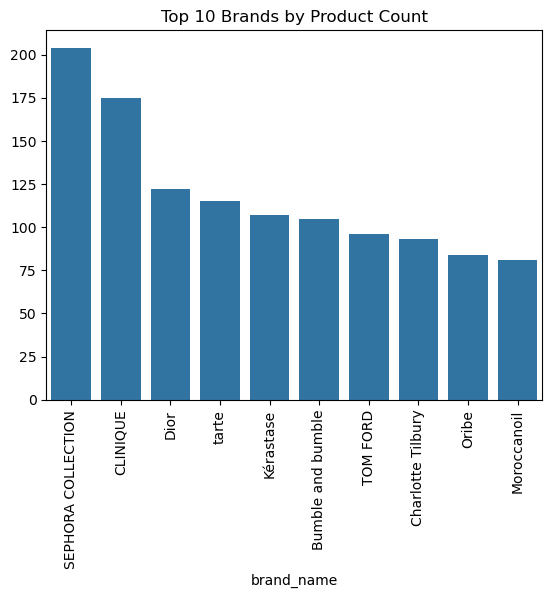

In [ ]:

brand_count = df['brand_name'].value_counts().nlargest(10)
sns.barplot(x=brand_count.index, y=brand_count.values)
plt.title('Top 10 Brands by Product Count')
plt.xticks(rotation=90)
plt.show()


Distribution of the price, ratings, and loves count across all products

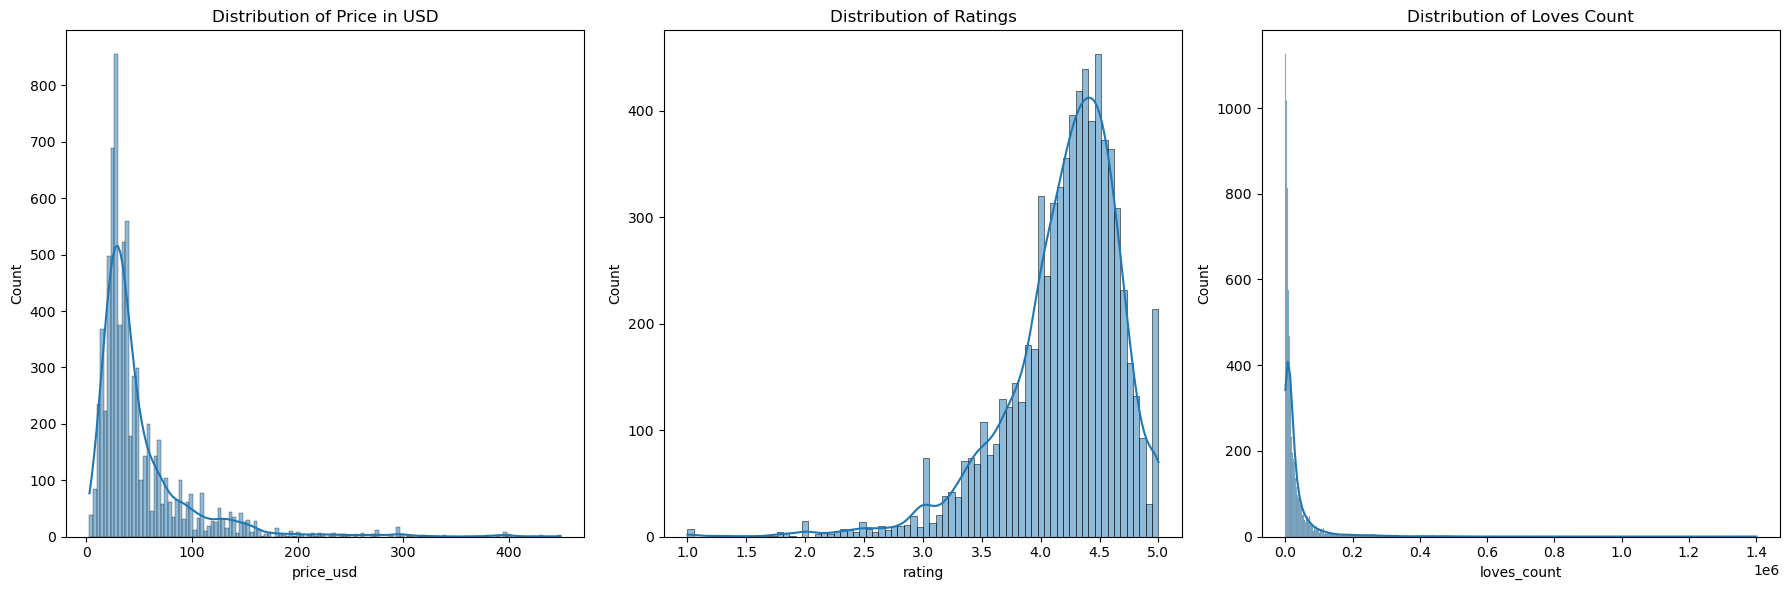

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Price histogram
sns.histplot(df['price_usd'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price in USD')

# Rating histogram
sns.histplot(df['rating'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Ratings')

# Loves count histogram
sns.histplot(df['loves_count'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Loves Count')

plt.tight_layout()
plt.show()



Prive vs rating sactterplot

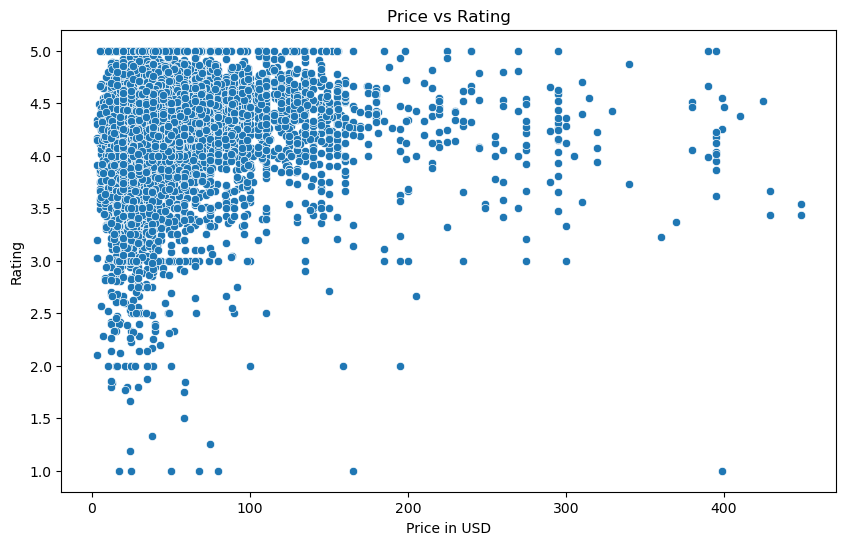

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price_usd', y='rating', data=df)
plt.title('Price vs Rating')
plt.xlabel('Price in USD')
plt.ylabel('Rating')
plt.show()


In [25]:
df['reviews'].mean()

np.float64(478.3011472275335)

# 3. Popularity Score 

First we need to do some scaling for the rating , as some products might have a super small amount of reviews and still have a rating of 5 

In [ ]:
df['scaled_rating'] = df['rating'] * (df['reviews'] / df['reviews'].max())

Now we define the popularity as a weighted sum of the 3 factors we considered most important. 

In [30]:
w_loves = 0.5
w_rating = 0.3
w_reviews = 0.2

Also, we will apply Min-Max scaling to each individual feature before combining them into the popularity score. This way, the popularity score will naturally be within a bounded range.

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Scale individual features before combining them
scaler = MinMaxScaler()
df[['loves_count', 'sacaled_rating', 'reviews']] = scaler.fit_transform(df[['loves_count', 'scaled_rating', 'reviews']])

# Calculate the popularity score
df['popularity_score'] = (w_loves * df['loves_count'] +
                           w_rating * df['scaled_rating'] +
                           w_reviews * df['reviews'])

# 4. Study the popularity among other factors 


                  popularity_score  n_highlights  n_ingredients  brand_id
popularity_score          1.000000      0.055612      -0.025062 -0.062687
n_highlights              0.055612      1.000000       0.088142  0.311255
n_ingredients            -0.025062      0.088142       1.000000  0.027205
brand_id                 -0.062687      0.311255       0.027205  1.000000


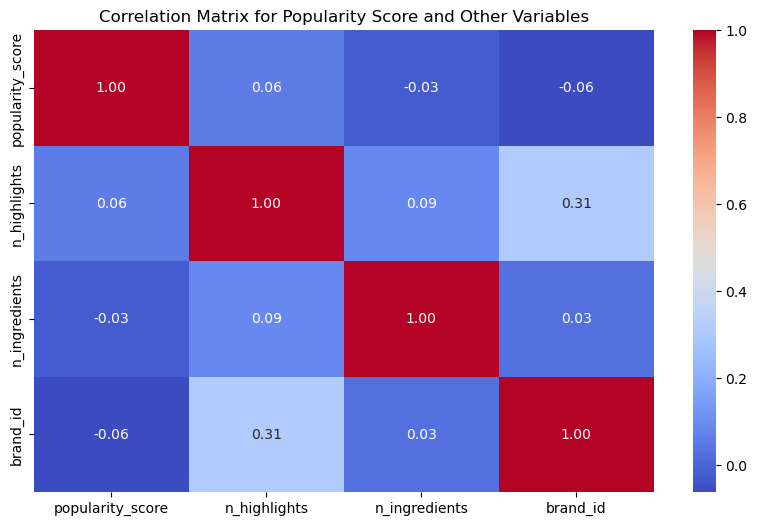

In [ ]:
correlation_columns = ['popularity_score',  'n_highlights', 'n_ingredients', 'brand_id']


correlation_matrix = df[correlation_columns].corr()
print(correlation_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Popularity Score and Other Variables')
plt.show()
